In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, xlabel, ylabel
%matplotlib inline
from matplotlib.path import Path
from matplotlib.figure import Figure
from matplotlib.patches import PathPatch
from matplotlib.patches import Patch
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import matplotlib.cm as cm
from IPython.core.display import display
import matplotlib.patches as patches
import math
import numpy as np
from numpy import percentile
from numpy.random import seed
import os
from sklearn.preprocessing import StandardScaler
import datetime as dt
import time
import glob
import pickle
import spacy
import re
import pyodbc
import sqlalchemy as sal
from sklearn.preprocessing import normalize 
from sqlalchemy import create_engine
import pandas as pd
from scipy.stats import bartlett
from scipy.stats import boxcox
from sklearn.preprocessing import normalize 
from scipy.stats import jarque_bera
from scipy.stats import levene
from scipy.stats import normaltest
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from scipy.stats import zscore
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score #
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import precision_recall_curve
from sklearn import preprocessing as pp
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
import xlsxwriter
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, \
    adjusted_mutual_info_score, adjusted_rand_score
from sklearn.metrics import silhouette_samples,  silhouette_score
from sklearn.metrics.cluster import contingency_matrix

import en_core_web_md
nlp = spacy.load('en_core_web_md')
from random import sample 
import dask.dataframe as dd
from dask import delayed, compute

In [4]:
import_csv_path = 'D:\\dev_data\\re\\pro\\fls\\pre_dask\\'
files = os.listdir(import_csv_path )
file_list = [import_csv_path+i for i in files]

@delayed
def read_CSVs(file_list):
        master_ddf = dd.read_csv(file_list, dtype={'estate_mask': 'float64'})
        return master_ddf


In [5]:
read_CSVs(file_list)

Delayed('read_CSVs-f838e26e-41c5-4826-8163-751118528662')

In [6]:
@delayed
def train_test_ddf_creator(ddf):
    train_test_ddf = ddf[ddf['source']=='lookup'].copy()
    train_test_ddf = train_test_ddf.reset_index(drop=True)
    return train_test_ddf


In [9]:
train_test_ddf_creator(read_CSVs)

Delayed('train_test_ddf_creator-abb62b56-b474-47ca-ac85-d9753f410b58')

In [113]:
# @delayed
# def query_ddf_creator(ddf):
#     query_ddf = ddf[ddf['source']=='query'].copy()
#     query_ddf = query_ddf.reset_index(drop=True)
#     return query_ddf

In [10]:
@delayed
def lookup_names_creator(train_test_ddf, ddf_master):
    lookup_names = train_test_ddf(ddf_master)['MAILTO_cleaned2'].values
    return lookup_names

In [12]:
lookup_names_creator(train_test_ddf_creator, read_CSVs)

Delayed('lookup_names_creator-d11d52e4-e090-4b78-b874-3e6e61b312fb')

In [13]:
@delayed
def lookup_query_names_creator(lookup_names, query):
    lookup_query_names = np.append(lookup_names, query)
    return lookup_query_names

In [15]:
lookup_query_names_creator(lookup_names_creator, query=['garcia antonio'])

Delayed('lookup_query_names_creator-686b1af4-04c6-40e3-a7e9-836d6e4d68b8')

In [16]:
@delayed
def targets_creator(lookup_query_names):
    targets = [1] * lookup_query_names.size
    return targets

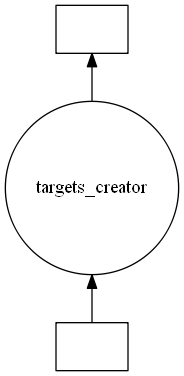

In [22]:
targets_creator(lookup_names_creator).visualize()


In [19]:
@delayed
def KNN_metrics_creator(lookup_query_names, targets):
    vectorizer3 = TfidfVectorizer(decode_error='replace', strip_accents='unicode', analyzer='word', ngram_range = (1, 1)  , norm=u'l2', use_idf=True, smooth_idf=True, sublinear_tf=True)
    X_and_1_query = vectorizer3.fit_transform(lookup_query_names)
    knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean', weights='distance', n_jobs=-1)
    knn.fit(X_and_1_query[:-1,:], targets)
    distances, indices = knn.kneighbors(X_and_1_query[-1])
    return distances, indices

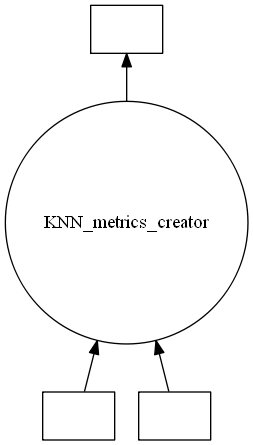

In [21]:
post_knn = KNN_metrics_creator(lookup_query_names_creator, targets_creator)
post_knn.visualize()

In [23]:
delayed_results = [delayed(KNN_metrics_creator)(lookup_query_names_creator, targets_creator)]
post_knn = compute(*delayed_results, scheduler="processes")

TypeError: 'function' object is not iterable